#Sammanfattning
Detta projekt har gjorts i samband med en kurs på Umeå Univeristet där det mesta av koden kommer ifrån googles egna GAN (https://www.tensorflow.org/tutorials/generative/dcgan). Syftet med projektet är att skapa en modell som utifrån MNIST lär sig att generera "handskrivna" siffror. Detta sker genom användandet av GAN. GAN står för Generative Adversial Network. Grundenmetodiken i GANs består av en kombination av två neurala nätverk. Där det ena nätverket är av en genererande typ(generator) medans det andra nätverket är av en klassificerande typ(discriminator). Det ena nätverket försöker alltså generera bilder som ser verkliga ut, medan det andra nätverket klassificerar bilderna som verkliga eller overkliga. När det klassificerande nätverket inte längre klarar av att skilja på fiktion och verklighet så har GAN-nätverket antagligen lyckats skapa ganska bra bilder. Det är just metodiken med två nätverk som triggar varandra som särskiljer GAN från många andra typer av nätverk och som gör att vi kan få ut så pass bra bilder, för i takt med att generatorn justeras för att skapa verkligare bilder så justeras också diskriminatorn för att bättre kunna avögra vad som är riktigt och vad som inte är det. Så även om GAN som helhet har ett mål om att producera så bra bilder som möjligt så har det två olika delnätverken helt egna och separata mål. I och med att dessa två mål står i motsats till varandra så blir det som en intern tävling inuti GAN, där båda dessa nätverk försöker uppnå sina mål. För att förstå detta bättre kan man jämföra det med en polis och en tryckare av låtsas-pengar, där utvecklingen av tryckandet hela tiden ställer högre och högre krav på polisen som måste finslipa sina metoder för verifiering av pengar vilket leder till att tryckarna skapar nya metoder för att ta fram låtsas-pengar osv. Denna utveckling sker hela tiden internt i de båda nätverken när de allt eftersom justerar sig själva för att ta fram bättre och mer precisa metoder.

#Importerar bibliotek
Hämtar olika bibliotek för senare användning. Försöker hämta senaste tensorflow-versionen och skriver ut hämtad version.

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
tf.__version__
# To generate GIFs
!pip install imageio
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

#Laddar datan och förbereder datan
Hämtar datan, omformar den samt normaliserar den.

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#Skapar generatorn
Här skapas generator-model. Denna generator är tagen från google tutorial och innehåller ett alla-till-alla-lager(dense) samt tre faltningslager, där två av dessa använder sig utav strides med icke-default-värden. Samtliga faktningslager använder sig utav padding.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

#Visar bild
1. Hämtar modellen och sparar den i en variabel.

2. Ger generatorn en randomiserad input som argument och sparar sedan den genererade datan i en variabel. Vår input är det som allteftersom kommer transformeras till vår slutgiltiga output. Där vårt dataset inte ges direkt till generatorn utan snarare påverkar generatorn indirekt via diskriminatorn.

3. Visar bilden.

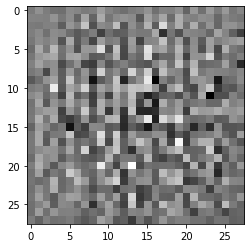

In [ ]:
#1. 
generator = make_generator_model()

#2.
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

#3.
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

#Skapar diskriminatorn
Skapar en sekventiell modell med tre lager neurala lager(två convolutional och ett alla-till-alla-lager som output). Emellan dessa olika lager så används också dropouts för att undvika overfitting. Detta sker genom att olika neuroner ignoreras under träningen. Utöver detta så används också LeakyReLU som aktiveringsfunktion till de båda faltningslagren. Dessa två lager använder sig också av padding och strides. Filter storleken anges till 5x5. Vår funktion returnerar sedan modellen i sin helhet.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

#Skriver ut diskriminatorns uppskattning
Diskriminatorn hämtas och sparas i en variabel, diskriminatorn anropas sedan med vår tidigare genererade bild som argument i retur får vi diskriminatorns uppskattning av bildens giltighet. Denna uppsktattning skrivs sedan utan genom Pythons print-funktion.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00110725]], shape=(1, 1), dtype=float32)


#Definerar loss- och optimeringsfunktionerna

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#Definerar diskriminatorns loss-funktion
Definerar diskriminatorns loss-funktion, dvs. hur väl diskriminatorn kunde förutsäga huruvida en bild var fake eller riktig.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#Definerar generatorns loss-funktion
Definerar generatorns loss-funktion, dvs. hur väl generatorn kunde lura diskriminatorn att bilden den producerade var riktig.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#Definerar optimiseringsfunktion
Definerar två olika optimiseringsfunktioner åt de de två nätverken då de tränas separat.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#Sparar checkpoints

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#Definerar träningsloopen
Träning av GANs sker genom seperat träning av de båda nätverken. Denna träning sker inte parallellt, utan de båda nätverken växlar av varandra i sin träning för att på så sätt utvecklas bitvis. När det ena nätverket blir lite bättre leder det till att det andra nätverket också blir lite bättre.

In [ ]:
#Här defineras antalet epoker
EPOCHS = 50
#Här defineras vårt noise
noise_dim = 100

#Här anger vi hur många bilder vi vill generera för varje omgång
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)i
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


#Definerar en funktion för träningen av GAN

In [ ]:
def train(dataset, epochs):
  #Tar tid för varje epok
  for epoch in range(epochs):
    start = time.time()

    
    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

#Definerar en funktion för att generera och spara bilder


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

#Tränar modellen

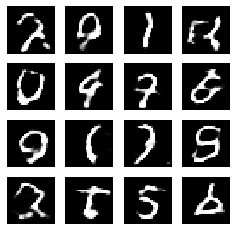

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

#Skapar GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(EPOCHS)

NameError: ignored

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

NameError: ignored